Load Spark, haddop, pycountry, pygal, and pygal_maps_world

In [1]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.3/spark-3.2.3-bin-hadoop2.7.tgz
!tar xf spark-3.2.3-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pycountry
!pip install pygal
!pip install pygal_maps_world
!pip install cairosvg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.1 MB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681845 sha256=2cd15d1ab2a3c065b0172897c18ba6ec04a0b374fb5d0e2a33ed89aaaae0a7ea
  Stored in directory: /root/.cache/pip/wheels/e2/aa/0f/c224e473b464387170b83ca7c66947b4a7e33e8d903a679748
Successfully built pycountry
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 129 kB 3.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 270 kB 4.1 MB/s 
  Created wheel for pygal-maps-world: filename=pygal_maps_world-1.0.2-py3-none-any.whl size=278560 sha256

Unzip Tempature data and input path to it for later use

In [20]:
!unzip /content/drive/MyDrive/Cs631_Data/data/country-land-sufrace-temperature.zip -d data # enter your own directory

# Uncomment if run in colap to clear output
from google.colab import output
output.clear()

In [21]:
# Path to date files
path = "/content/data/files"
assert path != None, "Please set path variable to text_files from the temperature data"

Initialize Spark

In [22]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.3-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark import SparkContext, SparkConf

spark_conf = SparkConf()\
  .setAppName("YourTest")\
  .setMaster("local[*]")

sc = SparkContext.getOrCreate(spark_conf)
from pyspark.sql import SparkSession
import random

spark = SparkSession.builder.appName("YourTest").master("local[2]").config('spark.ui.port', random.randrange(4000,5000)).getOrCreate()

In [23]:
import matplotlib.pyplot as plt
import pygal_maps_world, pygal
import numpy as np
import glob,re,math,pycountry,linecache,unicodedata
from math import isnan
from pyspark.sql import functions as F
from pyspark.sql.functions import avg,lag, col
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler,PolynomialExpansion
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pygal.style import Style
from pygal_maps_world.maps import World
custom_style = Style(colors=('#87c4fa','#ecfc72','#ff3b5b','#000000'), label_font_size=10, legend_font_size = 10)
from IPython.display import SVG, display

Load data, clean away text, and put the data into dataframes
The dataframes cann be accesed through the:
- *df_dict* (which contains them all)
- names are contained in *country_names* for index in the dict

In [24]:
# strip_accents is taken from Oefe: https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string
def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')  

# For splitting the text data
re_split = r"(?<![\w\d])NaN(?![\w\d])|[\d.-]+" # remove NaN's
re_name = r"^[a-zA-Z]+" # Find true name from path
re_base_temp_line = re.compile("Estimated Jan 1951-Dec 1980 absolute temperature") # Find line with base temp and var
re_base_temp_numbers = r"[\d.-]+" # isolate base temp and var

# Find names of all files in data dict
list_file_names = glob.glob(path+"/*")
# Column names for the dataframes
col_names = ["Year", "Month",  "MonthAnomaly", "MonthUnc",   "YearAnomaly", "YearUnc",   "5YearAnomaly", "5YearUnc",   "10YearAnomaly", "10YearUnc",   "20YearAnomaly", "20YearUnc"]
# Define dict for datframes:
df_dict = {}
country_names = []  

# Will be used later to generate alpha2 codes for the countries
# which is used in plotting them on the world map 
conversion_table = {}

# Check for if the comma has been removed from "bonaire, saint eustatius and saba.txt"
re_check = r"[,]+"
for file_name in list_file_names:
  assert len(re.findall(re_check,file_name)) == 0, f"Remove comma from {file_name}"

# read files to dataframes
for file_name in list_file_names:
  lines = sc.textFile(file_name)

  base_temp_var = lines.filter(lambda x: re_base_temp_line.findall(x)).map(lambda x: re.findall(re_base_temp_numbers,x)).map(lambda l: [float(l[i]) for i in [-3,-1]]).collect()[0]
  name = strip_accents("_".join(re.findall("[\w]+",file_name)[3:-1]))

  raw_df = lines.filter(lambda x: x[0]!='%').map(lambda x: re.findall(re_split,x)).filter(lambda x: len(x)!=0)
  df = raw_df.toDF(col_names).cache()
  df = df.withColumn("MonthTemp",F.col("MonthAnomaly")+base_temp_var[0])
  df = df.withColumn("YearTemp",F.col("YearAnomaly")+base_temp_var[0])
  df = df.withColumn("5YearTemp",F.col("5YearAnomaly")+base_temp_var[0])
  df = df.withColumn("10YearTemp",F.col("10YearAnomaly")+base_temp_var[0])
  df = df.withColumn("20YearTemp",F.col("20YearAnomaly")+base_temp_var[0])

  df = df.withColumn("MonthUNC",F.col("MonthUNC")+base_temp_var[1])
  df = df.withColumn("YearUNC",F.col("YearUNC")+base_temp_var[1])
  df = df.withColumn("5YearUNC",F.col("5YearUNC")+base_temp_var[1])
  df = df.withColumn("10YearUNC",F.col("10YearUNC")+base_temp_var[1])
  df = df.withColumn("20YearUNC",F.col("20YearUNC")+base_temp_var[1])

  df.createOrReplaceTempView(name)
  df_dict[name]=df
  country_names.append(name)
  conversion_table.update({name : file_name.strip()[len(path)+1:-4]})

Get Continent dataset and create dataframe:

In [27]:
!unzip /content/drive/MyDrive/Cs631_Data/data/Country_to_Continent.zip -d data_c2c
# output.clear()

Archive:  /content/drive/MyDrive/Cs631_Data/data/Country_to_Continent.zip
  inflating: data_c2c/countryContinent.csv  


In [28]:
CtC_df=spark.read.format("csv").option("header","true").load("/content/data_c2c/countryContinent.csv").cache()
CtC_df.createOrReplaceTempView("CtC_df")

Create CO2 Dataframe

In [29]:
lines_raw = sc.textFile("/content/drive/MyDrive/Cs631_Data/data/co2_mm_mlo.csv")
lines = lines_raw.filter(lambda x: x[0] != "#")
df_raw = lines.map(lambda x: re.findall(re_base_temp_numbers,x)).filter(lambda x: len(x)!=0)
col_names = ["year","month","decimal" "date","average","deseasonalized","ndays","sdev","unc"]
CO2_df = df_raw.toDF(col_names).cache()
CO2_df.createOrReplaceTempView("CO2_df")
# CO2_df = CO2_df.withColumn("year",F.col("year")+0.0)

In [30]:
# type(spark.sql("select year from CO2_df").rdd.flatMap(lambda x: x).take(1)[0])

# 1- Overview and comaprison of country temperature over the years

In [31]:
# Support functions
from math import isnan

def check_nan2(x):
  if isnan(x[1][0]) == True:
    return (x[0],(0,0,1e-5))
  else:
    return (x[0],(x[1][0],x[1][1],1))

# Stolen from dingo_d: https://stackoverflow.com/questions/11352047/finding-moving-average-from-data-points-in-python
def moving_average(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def continent_plt(continent,plt_x,plt_cols,N_vars):
  # find countries from a specific continent (cfc=contries from continent)
  cfc = CtC_df.select("country"
                        ).filter(CtC_df.continent == continent
                        ).rdd.flatMap(lambda x: x
                        ).collect()

  available_cfcs = [cfc_i.lower() for cfc_i in cfc if cfc_i.lower() in list(df_dict.keys())]

  plt_data_raw_rdd = df_dict[available_cfcs[0]].select(plt_x[0],*plt_cols).rdd

  for current in available_cfcs[1:]:
    rdd_tmp = df_dict[current].select(plt_x[0],*plt_cols).rdd
    plt_data_raw_rdd = plt_data_raw_rdd.union(rdd_tmp)

  # gets data from dataframe
  plt_data_raw = plt_data_raw_rdd.map(lambda x: (int(x[0]),(float(x[1]),float(x[2])))
                              ).map(lambda x: check_nan2(x)).filter(lambda x: x[1][0] != "0"
                              ).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1], a[2]+b[2])
                              ).mapValues(lambda v: (v[0]/v[2],v[1]/v[2])
                              ).sortByKey(
                              ).flatMap(lambda x: (x[0],x[1][0],x[1][1])).collect()
  
  # Transform and sort data
  plt_data_raw_np = np.array(plt_data_raw,dtype=float)
  plt_data = np.array([plt_data_raw_np[i::N_vars] for i in range(3)])

  # split data into types
  x = plt_data[0]
  y = plt_data[1]
  y_unc = plt_data[2]
  return x,y,y_unc

def co2_plot():
  plt_data_raw = CO2_df.select("year","average","unc").rdd.map(lambda x: (int(x[0]),(float(x[1]),float(x[2])))
                              ).map(lambda x: check_nan2(x)).filter(lambda x: x[1][0] != "0"
                              ).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1], a[2]+b[2])
                              ).mapValues(lambda v: (v[0]/v[2],v[1]/v[2])
                              ).sortByKey(
                              ).flatMap(lambda x: (x[0],x[1][0],x[1][1])).collect()
      
  # Transform and sort data
  plt_data_raw_np = np.array(plt_data_raw,dtype=float)
  plt_data = np.array([plt_data_raw_np[i::3] for i in range(3)])

  x = plt_data[0]
  y = plt_data[1]
  y_unc = plt_data[2]

  return x,y,y_unc

def country_plot(current, N_vars):
  # gets data from dataframe
  plt_data_raw = df_dict[current].select("Year","YearTemp","YearUNC").rdd.map(lambda x: (x[0],(x[1],x[2]))
                          ).map(lambda x: check_nan2(x)).filter(lambda x: x[1][0] != "0"
                          ).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1], a[2]+b[2])
                          ).mapValues(lambda v: (v[0]/v[2],v[1]/v[2])
                          ).sortByKey(
                          ).flatMap(lambda x: (x[0],x[1][0],x[1][1])).collect()
  
  # Transform and sort data
  plt_data_raw_np = np.array(plt_data_raw,dtype=float)
  plt_data = np.array([plt_data_raw_np[i::N_vars] for i in range(N_vars)])

  # split data into types
  x = plt_data[0]
  y = plt_data[1]
  y_unc = plt_data[2]

  return x,y,y_unc

Compare two countries:

In [32]:
def compare_multiple(entities, plt_x,plt_cols,window_size = 10, rolling_mean=False, unc = True):

  fig, ax = plt.subplots(figsize=(15, 5))

  N_vars = len(plt_x)+len(plt_cols)
  # plt.rcParams["figure.figsize"] = (15,5)
  names = []
  currently_co2 = False

  for j in range(len(entities)):
    current = entities[j].lower()

    # Decide how to process input:
    if current.lower() == "co2":
      currently_co2 = True
      x,y,y_unc = co2_plot()

    elif current.lower() in CONTINENTS:
      x, y, y_unc = continent_plt(current[0].upper()+current[1:],plt_x,plt_cols,N_vars)

    else:
      x,y,y_unc = country_plot(current, N_vars)

    # make bad nan's into nans again after having been 0's
    y[y==0] = np.nan

    # find upper and lower uncertainty
    y_unc_upper = y+y_unc
    y_unc_lower = y-y_unc

    # check if the current one is CO2, cause that one needs different plotting:
    if not currently_co2:

      if rolling_mean.lower() != "only":
        ax.plot(x,y)
        names.append(current)

      if unc:
        ax.fill_between(x=x, y1=y_unc_upper,y2=y_unc_lower,alpha=0.1)

      if rolling_mean.lower() != "false":
        ax.plot(x[window_size-1:-window_size-1],moving_average(y,window_size)[window_size-1:-window_size-1])
        names.append(current+"_roll_avg")
     
    else:
      ax_co2=ax.twinx()
      ax_co2.set_ylabel("CO2 concentration in parts per million")
      # ax_co2.set_xlabel("Year")
      ax.grid()
      if rolling_mean.lower() != "only":
        ax_co2.plot(x,y,label="CO2",c = "black")
        ax.plot([2000],[0],c="black")
        names.append("CO2")

      if unc:
        ax_co2.fill_between(x=x, y1=y_unc_upper,y2=y_unc_lower,alpha=0.1,color="black")

      if rolling_mean.lower() != "false":
        ax_co2.plot(x[window_size-1:-window_size-1],moving_average(y,window_size)[window_size-1:-window_size-1],label="CO2_roll_avg",c="black")

      ax.legend(names)

  ax.set_xlabel("  Year")
  ax.set_ylabel("  Temp in C")
  ax.legend(names)
  ax.grid()
  plt.title(", ".join(entities)+" over the years")
  plt.show()

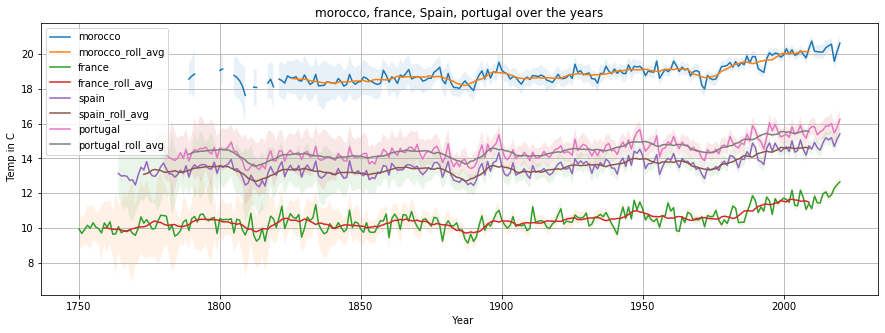

In [33]:
CONTINENTS = ["asia","africa","europe", "oceania", "americas"]


countries = ["morocco","france","Spain","portugal"] # What countries to plot. The Countries to plot can be found in df_dict.keys()
window_size = 10 # int. Rolling average size
rolling_mean = "True" # ["False","True","Only"]. If the rolling mean should be included
unc = True # Bool. to include uncertainty
compare_multiple(countries, ["Year"] ,["YearTemp","YearUNC"],window_size = window_size, rolling_mean=rolling_mean, unc = unc)



# 2- World Map

In [34]:


manual_fixes = {'burma': 'myanmar', 'cape_verde': None, 'denmark_europe': 'denmark',
                'virgin_islands' : None, 'reunion': None, 'netherlands_europe' : 'netherlands',
                'sint_maarten': None, 'saint_martin': None,'palestina' : 'Palestine, State of',
                'macau' : None, 'kingman_reef' : None, 'laos': "Lao People's Democratic Republic",
                'falkland_islands_islas_malvinas':'Falkland Islands (Malvinas)', 'turks_and_caicas_islands': None,
                'france_europe': 'France', 'macedonia':'North Macedonia', 'bonaire_saint_eustatius_and_saba': None,
                'baker_island': None, 'south_georgia_and_the_south_sandwich_isla': None, 'swaziland': 'Eswatini',
                'syria':'Syrian Arab Republic', 'russia' : 'Russian Federation', 'gaza_strip': None,
                'palmyra_atoll': None, 'united_kingdom_europe' : 'United Kingdom', 'french_southern_and_antarctic_lands': None,
                'aland' : 'Åland Islands', 'iran' : "Iran, Islamic Republic of", 'congo_democratic_republic_of_the' : "Congo, The Democratic Republic of the"
                
               }

def get_alpha2(country):
   
    if country in manual_fixes:
        miss = manual_fixes[country]
        if miss is not None:
            return pycountry.countries.lookup(miss).alpha_2.lower()
        else:
            return None
    else:
        try:
            return pycountry.countries.lookup(country.replace("_"," ")).alpha_2.lower()
        except LookupError:
            return pycountry.countries.lookup(conversion_table[country]).alpha_2.lower()
        
alpha2_codes = {country: get_alpha2(country) for country in country_names}

In [35]:
relevant_countries = [country for country in country_names if alpha2_codes[country] is not None]

In [36]:
def get_avg_temp(country, year):
    
    
    avg_temp = df_dict[country].filter(f'Year == {year}').select('MonthTemp').rdd.map(lambda x: x[0]).filter(lambda x: not math.isnan(x)).mean()
  
    
    return {alpha2_codes[country] : avg_temp }


def get_values(year):
    
    values = {}

    for country in relevant_countries:
        values.update(get_avg_temp(country, year))
    
    return values

In [37]:

def render_map(year, render_browser=True, render_file=False):
    year = str(year)
    worldmap =  World(style=custom_style, title=year)


    values = get_values(year)
    
    low = {}
    medium = {}
    zero = {}
    high = {}
    
    for k, v in values.items():
        if v == 0:
            zero.update({k: v})
        elif v < 0:
            low.update({k: v})
        elif v < 10:
            medium.update({k: v})
        else:
            high.update({k: v})

    
    worldmap.add(f"T<0°C", low)
    worldmap.add(f"T∈(0°C;10°C)", medium)
    worldmap.add(f"T≥10°C", high)
    worldmap.add(f"N/A", zero)
    
    if render_browser:
        worldmap.render_in_browser()
    if render_file:
        worldmap.render_to_file(f'./{year}-worldtemperature.svg')
        worldmap.render_to_png(f'./{year}-worldtemperature.png')
    
    display(worldmap)

In [40]:
while True:
    print('Press enter to exit')
    year = input('Input a year (1750-2020) to have a temperature map generated ')

    year = year.strip().lower()
    
    if year == '':
        break
    else:
        print("All units are in celsius")
        print('Interact with the map in your browser')
        print('Map is being generated...')
        render_map(year, True, True)
        

Press enter to exit
Input a year (1750-2020) to have a temperature map generated 


# 3- Change of temperature over a given Monh for a given year

In [41]:

#creating custom dataframes for the upcoming visualizations
def createDF(countryname,selected = ["Year","Month","Anomaly-Mon","Unc-Mon","Anomaly-An","Unc-An"],cutoffL=1878,cutoffU= 2020):
  file1 = open("%s.txt"%countryname, 'r')
  col_names = ["Year","Month","Anomaly-Mon","Unc-Mon","Anomaly-An",
              "Unc-An","Anomaly-Fi","Unc-Fi","Anomaly-Ten","Unc-Ten",
              "Anomaly-Twe","Unc-Twe"]
  lines = file1.readlines()
  lineNums = []
  count = 1
  for line in lines:
    if "%%  Estimated" in line:
      avg_temp = float(line[line.find(":")+2: line.find("+/-")-1])
      unc_temp = float(line[line.find("+/-")+3:])
      #print(avg_temp)
    count+=1
    if line[0] != "%":
      lineNums.append(count)

  lines = []
  for i in lineNums:
    x = linecache.getline(r"%s.txt"%countryname, i).strip()
    lines.append(x)

  lines = list(map(lambda x : tuple(map(float,x)) ,list(map(lambda x : list((re.sub(r' +', ',', x).split(",")) ),lines))[:-1]))
  df = spark.createDataFrame(data=lines,schema = col_names)#.select(selected)
  df = df.withColumn("Anomaly-Mon", (df["Anomaly-Mon"] + avg_temp).cast('float') )
  df = df.withColumn("Anomaly-An", (df["Anomaly-An"] + avg_temp).cast('float') )
  df = df.withColumn("Anomaly-Fi", (df["Anomaly-Fi"] + avg_temp).cast('float')) 
  df = df.withColumn("Anomaly-Ten", (df["Anomaly-Ten"] + avg_temp).cast('float') )
  df = df.withColumn("Anomaly-Twe", (df["Anomaly-Twe"] + avg_temp).cast('float') )

  df = df.select(selected)
  return df.filter("Year >=%s"%cutoffL).filter("Year < %s"%cutoffU),unc_temp

In [52]:
#YEARLY PLOT (choose a year) and plot per month

def plot_yearly(df,year,unc_temp,colors = ["Green","Red"], uncertainty_threshold = .5,mon=1):
  # colors: designates the uncertainty (colors[0]-> low uncertainty, colors[1]-> high uncertainty)
  # uncertainty_threshold : pick a value for the threshold or "mean" to compute the overall mean
  # mon: 1 to compute temperature from monthly anomaly, any other value to compute it from the annual anomaly

  if mon==1:
    tit = "Monthly"
    col_p = "-Mon"
    ind_p = 3
  else:
    tit = "Annual"
    col_p = "-An"
    ind_p = 5

  if uncertainty_threshold== "mean":
    uncertainty_threshold = df.dropna().rdd.map(lambda x : x[ind_p]).mean()

  Low = df.filter("Year == %s"%year).select("Month","Anomaly"+col_p,"Unc"+col_p).rdd.map(lambda x : (x[0],x[1],x[2])).filter(lambda x: x[2]<uncertainty_threshold)
  High = df.filter("Year == %s"%year).select("Month","Anomaly"+col_p,"Unc"+col_p).rdd.map(lambda x : (x[0],x[1],x[2])).filter(lambda x: x[2]>=uncertainty_threshold)
  

  month_dico = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sept",10:"Oct",11:"Nov",12:"Dec"}
  months = df.filter("Year == %s"%year).select("Month").rdd.flatMap(lambda x : x).map(lambda x : month_dico[int(x)] ).collect()
  months_Low = Low.map(lambda x : month_dico[int(x[0])] ).collect()
  months_High = High.map(lambda x : month_dico[int(x[0])] ).collect()

  if len(months_High) + len(months_Low) ==0:
    print( "YEAR NOT AVAILABLE")
    return

  ano_M = df.filter("Year == %s"%year).select("Anomaly"+col_p).rdd.flatMap(lambda x : x).collect()
  ano_M_Low = Low.map(lambda x : (x[1]) ).collect()
  ano_M_High = High.map(lambda x : (x[1]) ).collect()
  un_low = df.filter("Year == %s"%year).select("Anomaly"+col_p,"UNC"+col_p).rdd.map(lambda x : x[0]-x[1]-unc_temp  ).collect()
  un_high = df.filter("Year == %s"%year).select("Anomaly"+col_p,"UNC"+col_p).rdd.map(lambda x : x[0]+x[1]+unc_temp  ).collect()
  


  fig = plt.figure(figsize = (14,7))
  ax = fig.add_subplot(1,1,1)
  xticks = months
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.plot(xticks, ano_M,'--',color="olive",label='_Hidden label')
  ax.scatter(months_Low, ano_M_Low ,c =colors[0], label="Uncertainty<%.3f"%(uncertainty_threshold+unc_temp)) # Makes no sense to have uncertainty on uncertainty like this
  ax.scatter(months_High, ano_M_High ,c =colors[1], label="Uncertainty>=%.3f"%(uncertainty_threshold+unc_temp))
  ax.fill_between(xticks, y1=un_high,y2=un_low,alpha=0.1)
  plt.xlabel("Months",size = 12)
  plt.ylabel("Temperature"+col_p,size = 12)
  plt.legend()
  plt.grid()
  
  plt.title("%s Temperature given the %s anomaly"%(year,tit))
  plt.show()




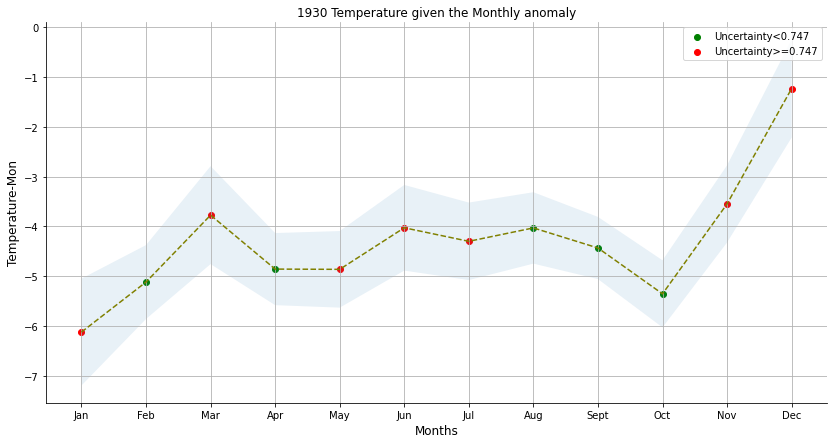

In [53]:
df,unc_temp = createDF(path + "/canada")
plot_yearly(df,1930,unc_temp,mon=1,uncertainty_threshold="mean")

# 4- Change of temperature over the years for a given Year

In [50]:

def plot_monthy(df,month,unc_temp,colors = ["Green","Red"], uncertainty_threshold = .5,mon=1,freq = 3):
  # colors: designates the uncertainty (colors[0]-> low uncertainty, colors[1]-> high uncertainty)
  # uncertainty_threshold : pick a value for the threshold or "mean" to compute the overall mean
  # mon: 1 to compute temperature from monthly anomaly, any other value to compute it from the annual anomaly
  # freq: xticks frequency
  month = int(month)
  if month>12 or month<1:
    return "Choose a month number between 1 and 12"
  if mon==1:
    tit = "Monthly"
    col_p = "-Mon"
    ind_p = 3
  else:
    tit = "Annual"
    col_p = "-An"
    ind_p = 5
  
  if uncertainty_threshold== "mean":
    uncertainty_threshold= df.dropna().rdd.map(lambda x : x[ind_p]).mean()
  month_dico = {1:"January",2:"February",3:"Mars",4:"April",5:"May",6:"June",7:"Jull",8:"August",9:"September",10:"October",11:"November",12:"December"}
  Low = df.filter("Month == %s"%month).select("Year","Anomaly"+col_p,"Unc"+col_p).rdd.map(lambda x : (x[0],x[1],x[2])).filter(lambda x: x[2]<uncertainty_threshold)
  High = df.filter("Month == %s"%month).select("Year","Anomaly"+col_p,"Unc"+col_p).rdd.map(lambda x : (x[0],x[1],x[2])).filter(lambda x: x[2]>=uncertainty_threshold)


  years = df.select("Year").orderBy("Year").distinct().rdd.flatMap(lambda x : x).map(lambda x : str(int(x))).sortBy(lambda x: x).collect()
  years_Low =  Low.map(lambda x : str(int(x[0]))).collect()
  years_High =  High.map(lambda x : str(int(x[0]))).collect()


  ano_Y = df.filter("Month == %s"%month).select("Anomaly"+col_p).rdd.flatMap(lambda x : x).collect()
  ano_Y_Low = Low.map(lambda x : (x[1]) ).collect()
  ano_Y_High = High.map(lambda x : (x[1]) ).collect()
  un_low = df.filter("Month == %s"%month).select("Anomaly"+col_p,"UNC"+col_p).rdd.map(lambda x : x[0]-x[1]-unc_temp ).collect()
  un_high = df.filter("Month == %s"%month).select("Anomaly"+col_p,"UNC"+col_p).rdd.map(lambda x : x[0]+x[1] ).collect()
  
  fig = plt.figure(figsize = (14,7))
  ax = fig.add_subplot(1,1,1)
  xticks = years
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.plot(xticks, ano_Y,'--',color="olive",label='_Hidden label')
  ax.scatter(years_Low, ano_Y_Low ,c =colors[0], label="Uncertainty<%.3f"%(uncertainty_threshold+unc_temp)) # same here
  ax.scatter(years_High, ano_Y_High ,c =colors[1], label="Uncertainty>=%.3f"%(uncertainty_threshold+unc_temp))
  ax.fill_between(xticks, y1=un_high,y2=un_low,alpha=0.1)
  plt.xlabel("Years",size = 12)
  plt.ylabel("Temperature"+col_p,size = 12)
  plt.legend()
  plt.xticks(xticks[::freq],rotation = 90)
  plt.grid()
  plt.title("month: %s Temperature given the %s anomaly"%(month_dico[month],tit))
  plt.show()

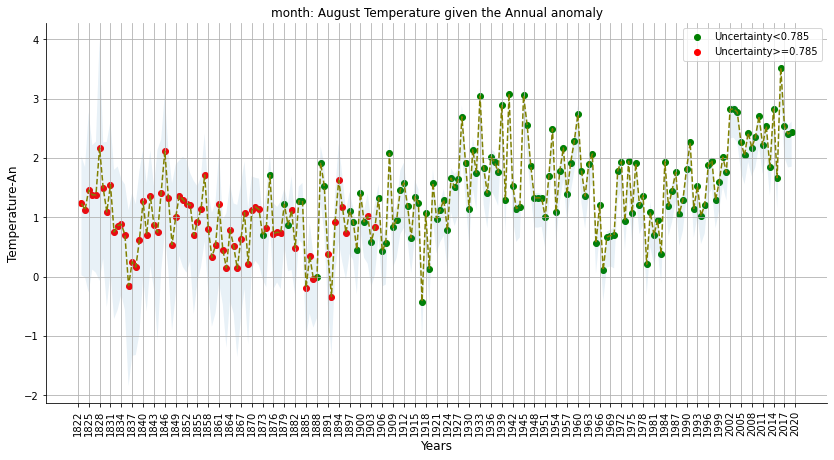

In [51]:
df,unc_temp = createDF(path + "/iceland",cutoffL=1822,cutoffU= 2022)
plot_monthy(df,8,unc_temp, uncertainty_threshold ="mean" ,mon=0,freq = 3)

# 5- Prediction of the temperature using historical data

In [46]:
#creating a shifted dataframe and splitting it into training and testing data and expanding the features
def shift_df_train_test(df,num_shifts=12,mon=1,train_perc = .7,d=4):
  # num_shifts: number of months to consider
  # mon: 1 to compute temperature from monthly anomaly, any other value to compute it from the annual anomaly
  # train_perc: training percentage
  # d: expansion degree
  w = Window().partitionBy().orderBy(col("Year"),col("Month"))
  num_shifts = 12
  df_shifted = df
  if mon==1:
    col_p = "-Mon"
    ind_p = 3
  else:
    col_p = "-An"
    ind_p = 5

  for i in range(1,num_shifts+1):
    df_shifted = df_shifted.select("*", lag("Anomaly"+col_p,offset=i).over(w).alias("shifted-Anomaly"+col_p+"-"+str(i)))

  df_shifted = df_shifted.na.drop()
  count = df_shifted.count() 
  train_row  = int(count *train_perc)
  train = spark.createDataFrame(df_shifted.head(train_row))
  test = df_shifted.subtract(train)

  input_cols = []
  input_cols.extend([ 'shifted-Anomaly'+col_p+"-"+str(i) for i in range(1,num_shifts+1)])
  vec_ass = VectorAssembler().setInputCols(input_cols).setOutputCol('X')

  df_train = vec_ass.transform(train).select("X","Anomaly"+col_p)
  df_test = vec_ass.transform(test).select("X","Anomaly"+col_p)
  px = PolynomialExpansion(degree=d, inputCol="X", outputCol="polyX")
  df_train = px.transform(df_train)
  df_test = px.transform(df_test)
  return df_shifted,df_train,df_test,col_p



In [47]:
df,_ = createDF(path + "/morocco")
_,df_train,df_test,col_p = shift_df_train_test(df,d=4) 

In [48]:
lr = LinearRegression().setFeaturesCol("polyX").setLabelCol("Anomaly"+col_p)
model = lr.fit(df_train)
evaluator = RegressionEvaluator().setLabelCol("Anomaly"+col_p)

test_pred = model.transform(df_test)
test_pred = test_pred.withColumn("prediction", ((test_pred["prediction"] ).cast('float')) )
print("testing data pred MAE :",evaluator.evaluate(test_pred, {evaluator.metricName: "mae"}))

train_pred = model.transform(df_train)
train_pred = train_pred.withColumn("prediction", ((train_pred["prediction"]).cast('float')) )
print("training data pred MAE :",evaluator.evaluate(train_pred, {evaluator.metricName: "mae"}))


testing data pred MAE : 1.1714934927272045
training data pred MAE : 0.6224242738775305


Prediction Visualization

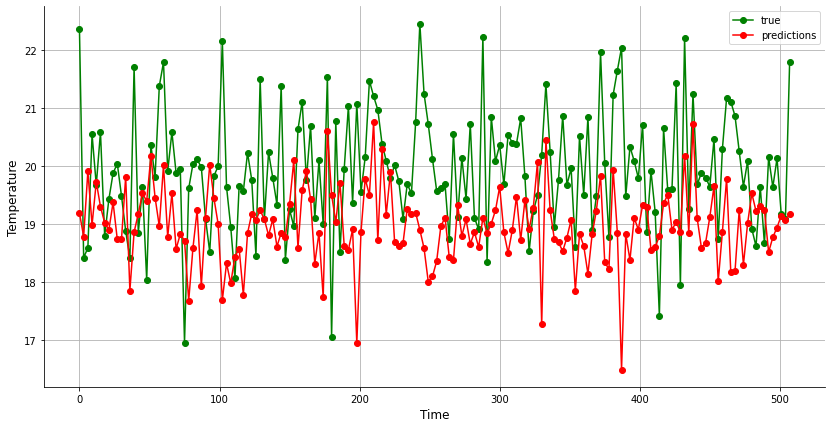

In [49]:
freq = 3
pred = test_pred.rdd.map(lambda x : x[3]).collect()
or_y = test_pred.rdd.map(lambda x : x[1]).collect()
years = np.arange(len(pred))[::freq]
fig = plt.figure(figsize = (14,7))
ax = fig.add_subplot(1,1,1)
xticks = np.sort(np.unique(years))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.plot(years, or_y[::freq],'-o',c="g",label = "true")
plt.plot(years, pred[::freq],'-o',c="r",label = "predictions")
plt.xlabel("Time",size = 12)
plt.ylabel("Temperature",size = 12)
plt.legend()
plt.grid()
plt.show()